In this module, we look at designing various camera geometries using `ctapipe.instrument.CameraGeometry` and explore their effects on reconstructing shower parameters 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ctapipe.instrument import CameraGeometry
from ctapipe.image import tailcuts_clean, toymodel
from ctapipe.image.hillas import hillas_parameters, HillasParameterizationError
import astropy.units as u
from ctapipe.visualization import CameraDisplay


plt.style.use("dark_background")
plt.rcParams["axes.facecolor"] = "0.15"
plt.rcParams["axes.grid"] = False


Designing a Square Grid Camera 

In [2]:
pix_type = "square"
size = 20 # Width of the square pixel in mm
pix_id = np.arange(0,256)

x_sq = (np.arange(-8,8) * size) + size/2.0
y_sq = (np.arange(-8,8) * size) + size/2.0
pix_x_sq, pix_y_sq = np.meshgrid(x_sq, y_sq)


pix_x_sq = pix_x_sq.ravel()*u.mm
pix_y_sq = pix_y_sq.ravel()*u.mm

pix_area_sq = np.power(size/1.05,2)*u.mm**2

geom_sq = CameraGeometry(
                        pix_id=pix_id, 
                        pix_x=pix_x_sq, 
                        pix_y = pix_y_sq, 
                        pix_area=pix_area_sq*np.ones([256]), 
                        pix_type=pix_type, 
                        name="Square Layout") 

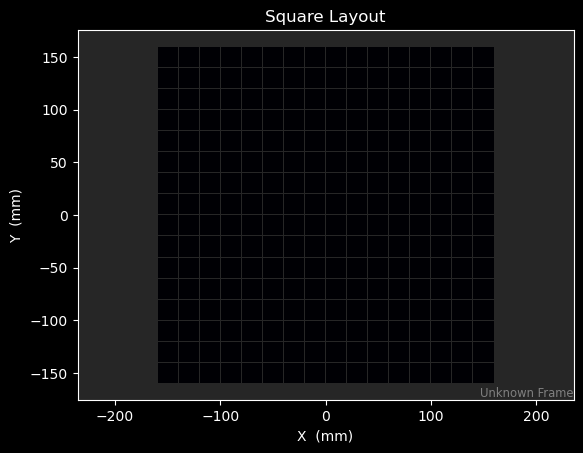

In [3]:
disp1= CameraDisplay(geom_sq, title="Square Layout")

A shower image can be generated using `ctapipe.image.toymodel()`. It supports two modes: Gaussian and skewnessewed Gaussian\
Once the shower model is generated, it can be projected onto the camera layout and displayed

In [4]:
model = toymodel.SkewedGaussian(
    x = 3 * u.mm,
    y = 10 * u.mm,
    length = 60 * u.mm,
    width = 25 * u.mm,
    skewness = 0.6,
    psi = 15.*u.deg
)

`sig_sq` contains signal from the shower, `bg_sq` has the night sky background (nsb) and `image_sq` holds both signal and nsb

In [5]:
image_sq, sig_sq, bg_sq = model.generate_image(geom_sq, intensity=1200, nsb_level_pe=6)

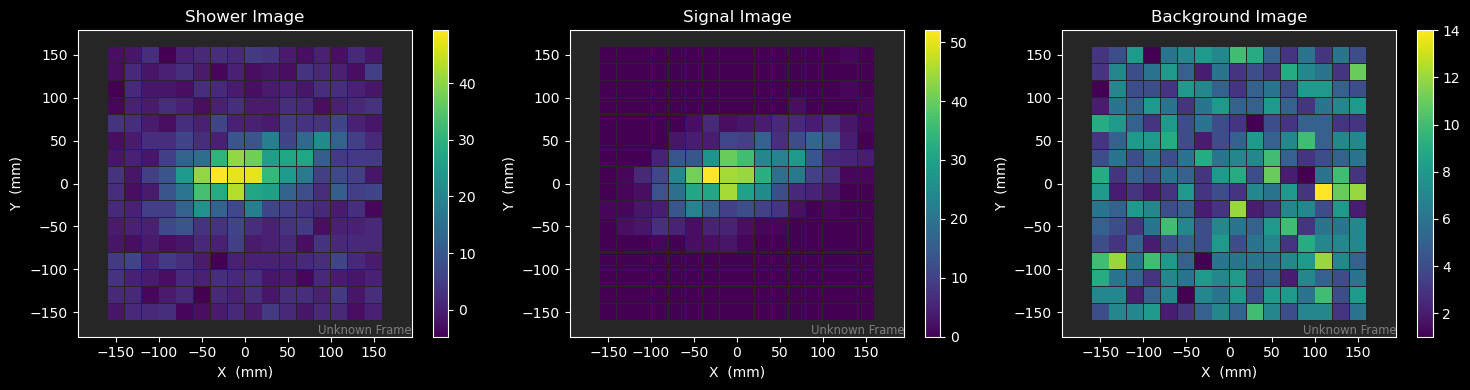

In [6]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
disp1 = CameraDisplay(geom_sq, ax = ax[0], title="Shower Image", cmap = 'viridis')
disp1.image = image_sq
disp2 = CameraDisplay(geom_sq, ax = ax[1], title="Signal Image", cmap = 'viridis')
disp2.image = sig_sq
disp3 = CameraDisplay(geom_sq, ax = ax[2], title="Background Image", cmap = 'viridis')
disp3.image = bg_sq

disp1.add_colorbar()
disp2.add_colorbar()
disp3.add_colorbar()
plt.tight_layout()

#### Hillas Parametrization
Observations consist of signal + noise. So the image has to be cleaned of the background before computing the Hillas Parameters
`ctapipe.image.tailcuts_clean` does this and returns a boolean mask of the pixels of the clean image

In [7]:
clean_image_sq_px = tailcuts_clean(geom_sq, image_sq, picture_thresh=10, boundary_thresh=5)
clean_image_sq = image_sq.copy()
clean_image_sq[~clean_image_sq_px] = 0
hillas_params_sq = hillas_parameters(geom_sq, clean_image_sq_px)

A plot of the original image with the clean image pixels highlighter in orange

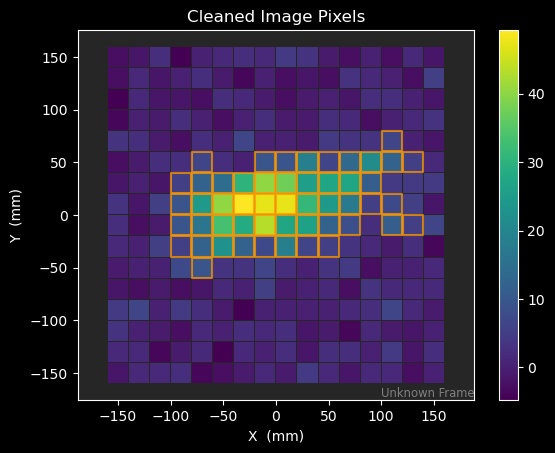

In [8]:
disp_clean = CameraDisplay(geom_sq, title="Cleaned Image Pixels", cmap = 'viridis')
disp_clean.image = image_sq
disp_clean.add_colorbar()
disp_clean.highlight_pixels(clean_image_sq_px, linewidth = 1.5, color = "#FF9A03")


Description of the HillasParameterContainer

In [9]:
from pprint import pprint
pprint(hillas_params_sq)

ctapipe.containers.CameraHillasParametersContainer:
                     intensity: total intensity (size) with default nan
                      skewness: measure of the asymmetry with default nan
                      kurtosis: measure of the tailedness with default nan
                             x: centroid x coordinate with default nan m [m]
                             y: centroid x coordinate with default nan m [m]
                             r: radial coordinate of centroid with default nan m
                                [m]
                           phi: polar coordinate of centroid with default nan
                                deg [deg]
                        length: standard deviation along the major-axis with
                                default nan m [m]
            length_uncertainty: uncertainty of length with default nan m [m]
                         width: standard spread along the minor-axis with
                                default nan m [m]
        

Compare the computed parameters to the input values in the toymodel


In [10]:
print(hillas_params_sq)

{'intensity': np.float64(51.0),
 'kurtosis': np.float64(1.9135275067435156),
 'length': <Quantity 65.50160655 mm>,
 'length_uncertainty': <Quantity 4.38326455 mm>,
 'phi': <Angle 0.76688176 rad>,
 'psi': <Angle 0.17093277 rad>,
 'psi_uncertainty': <Angle 0.06431912 rad>,
 'r': <Quantity 14.9765933 mm>,
 'skewness': np.float64(0.116649355584949),
 'transverse_cog_uncertainty': <Quantity 2.66720016 mm>,
 'width': <Quantity 27.13340348 mm>,
 'width_uncertainty': <Quantity 1.76366094 mm>,
 'x': <Quantity 10.78431373 mm>,
 'y': <Quantity 10.39215686 mm>}


Overlay the Hillas ellipse and other paramters on the clean image

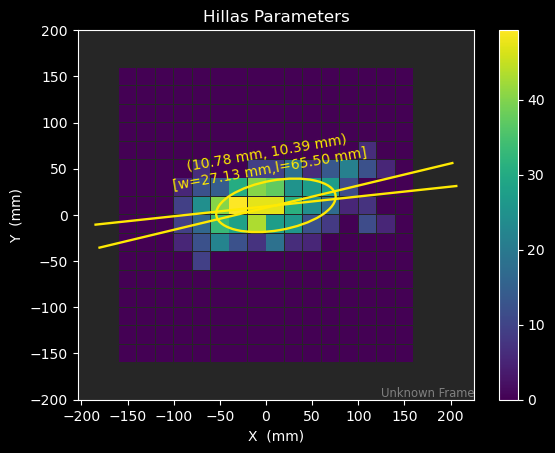

In [11]:
disp_hillas_sq = CameraDisplay(geom_sq, title="Hillas Parameters", cmap = 'viridis')
disp_hillas_sq.image = clean_image_sq
disp_hillas_sq.add_colorbar()
disp_hillas_sq.overlay_moments(hillas_params_sq, color = "#FFEA03", linewidth = 1.7)    

#### Exploring other camera geometries

**1.Brickwall Geometry**\
Every succeeding row is given an offset making the overall layout resemble a "brickwall". This reduces the distance between diagonal pixels resulting in better imaging of curved features seen in showers. The image reproduction quality lies between a square grid and a hex grid

In [12]:
size = 22
pix_id = np.arange(0,256)
x_br = (np.arange(-8,8) * size)+size/2.0 
y_br = (np.arange(-8,8) * size)+size/2.0
pix_x_br, pix_y_br = [], []
for i in range(len(y_br)):
    offset = size/2.0 if i%2==0 else 0
    for j in range(len(x_br)):
        pix_x_br.append(x_br[j]+offset)
        pix_y_br.append(y_br[i])
pix_x_br = np.array(pix_x_br)*u.mm
pix_y_br = np.array(pix_y_br)*u.mm
pix_type = "rectangular"
pix_area_br = np.power(size/1.05,2)*u.mm**2
geom_br = CameraGeometry(
        pix_id=pix_id, 
        pix_x=pix_x_br, 
        pix_y=pix_y_br, 
        pix_area=pix_area_br*np.ones([256]), 
        pix_type=pix_type, 
        name="Brickwall Layout")



**2. Hexagonal Geometry**

In [13]:
pix_type = "hexagonal"
size = 22
pix_id = np.arange(0,256)
pid = np.arange(0,256)
x_h = (np.arange(-8,8) * size)+size/2.0
y_h = (np.arange(-8,8) * size)+size/2.0

pix_x_h, pix_y_h = [], []
for i in range(len(y_h)):
    offset = size/2.0 if i%2==0 else 0
    for j in range(len(x_h)):
        pix_x_h.append(x_h[j]+offset)
        pix_y_h.append(y_h[i])
pix_x_h = np.array(pix_x_h)*u.mm
pix_y_h = np.array(pix_y_h)* u.mm
pix_area_h = np.power(size/1.05,2)*1e-6*u.m**2
geom_hx = CameraGeometry(
        pix_id=pix_id, 
        pix_x=pix_x_h, 
        pix_y = pix_y_h, 
        pix_area=pix_area_h*np.ones([256]), 
        pix_type=pix_type, 
        name="Hexagonal Layout")

   

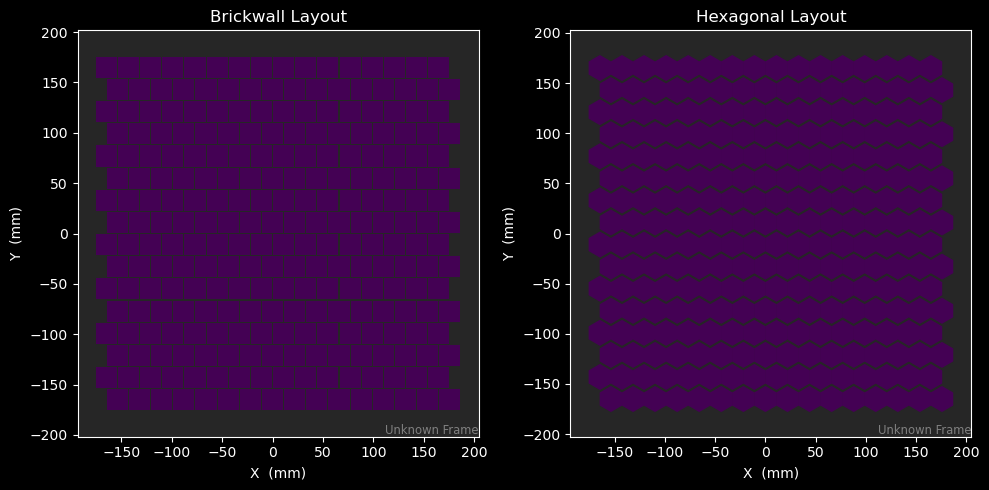

In [14]:

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
disp_br = CameraDisplay(geom_br, title="Brickwall Layout", cmap = 'viridis', ax=ax[0])
disp_hx = CameraDisplay(geom_hx, title="Hexagonal Layout", cmap = 'viridis', ax=ax[1])


plt.tight_layout()

Problem: 
1. Generate 500 showers images with a skewness of 0.6. 
+ Sample the length and width, rotation angle (psi) and the centroid coordinates from a uniform distribution (Ensure the limits of the distributions are set reasonably for the camera layouts designed).
+ Clean the images and compute the hillas parameters and plot the distribution of the reconstructed skewness. How does it compare to the input (constant) distribution? 
+ Which layout was able to beest reconstruct the parameter?
2. Some of the showers could be situated close to the edges of the camera and are partially captured. This could lead to an incorrect estimation of the skewness.\
 Use `CamereGeomtry.get_border_pixel_mask` to identify the border pixels and discard shower events that touch these pixels. Recompute the skewness distribution. Do you see an improvement in the reconstructed skewness? 

In [15]:
N = 5000
skewness = 0.6
psi = np.random.uniform(-90, 90, N) * u.deg # -90 to 90 degrees will suffice as anything beyond will just flip the sign of the reco skewness  
length, width = np.random.uniform(20,80, size = N), np.random.uniform(10,25, size = N)                                       

params_sq = {
"x_coord": np.random.uniform(np.min(pix_x_sq.value), np.max(pix_x_sq.value), size = N) * u.mm, 
"y_coord": np.random.uniform(np.min(pix_y_sq.value), np.max(pix_y_sq.value), size = N) * u.mm, 
"skewness": np.ones(N) * skewness,
"psi":  psi 
}

params_br = {
"x_coord": np.random.uniform(np.min(pix_x_br.value), np.max(pix_x_br.value), size = N) * u.mm, 
"y_coord": np.random.uniform(np.min(pix_y_br.value), np.max(pix_y_br.value), size = N) * u.mm, 
"skewness": np.ones(N) * skewness,
"psi": psi 
}

params_h = {
"x_coord": np.random.uniform(np.min(pix_x_h.value), np.max(pix_x_h.value), size = N) * u.mm, 
"y_coord": np.random.uniform(np.min(pix_y_h.value), np.max(pix_y_h.value), size = N) * u.mm, 
"skewness": np.ones(N) * skewness,
"psi": psi 
}
geom_n_param = {
            "geoms": [geom_sq, geom_br, geom_hx],
            "params": [params_sq, params_br, params_h]
}


intensity = 1200 # pe
bg = 6 

contained_events = [[],[],[]] # Boolean list to keep track of whether each event is contained or not for each geometry
length_reco_all, width_reco_all = [[],[],[]], [[],[],[]]
skewness_all = [[],[],[]]

x_reco_all = [[],[],[]]
y_reco_all = [[],[],[]]

for ind, (geom, param) in enumerate(zip(geom_n_param["geoms"], geom_n_param["params"])):
    size = 22.1
    eps = size * 0.5
    pix_x = geom.pix_x.to_value(u.mm)
    pix_y = geom.pix_y.to_value(u.mm)
    x_min, x_max = pix_x.min(), pix_x.max()
    y_min, y_max = pix_y.min(), pix_y.max()
    
    # border_pixels doesn't work for irregular square pixel geometries. 
    #border_pixels = geom.get_border_pixel_mask()
    
    border_pixels = (
        (np.isclose(pix_x, x_min, atol=eps)) |
        (np.isclose(pix_x, x_max, atol=eps)) |
        (np.isclose(pix_y, y_min, atol=eps)) |
        (np.isclose(pix_y, y_max, atol=eps))
    )
    for i in range(len(param["x_coord"])):
        
        x = param["x_coord"][i]
        y = param["y_coord"][i]
        sk = param["skewness"][i]
        psi = param["psi"][i]
        

        try:

            model = toymodel.SkewedGaussian(x, y, length = length[i]* u.mm , width= width[i] * u.mm, skewness= sk, psi = psi)

            image, sig, bg = model.generate_image(geom, intensity=intensity, nsb_level_pe=bg)

            mask = tailcuts_clean(geom, image, picture_thresh=10, boundary_thresh=5)

            clean = image.copy()
            clean[~mask] = 0.
            # Check if image touches border pixels
            image_pixels = (clean>0)
            hillas = hillas_parameters(geom, clean)
            touches_border = np.any(image_pixels & border_pixels)
            
            skewness_all[ind].append(hillas.skewness)
            length_reco_all[ind].append(hillas.length)
            width_reco_all[ind].append(hillas.width)
            x_reco_all[ind].append(hillas.x)
            y_reco_all[ind].append(hillas.y)


            if ~touches_border:
                contained_events[ind].append(True)

            else:
                contained_events[ind].append(False)

                continue



        except HillasParameterizationError:
            print("Error")
            skewness_all[ind].append(np.nan)
            contained_events[ind].append(False)
            length_reco_all[ind].append(np.nan * u.mm)
            width_reco_all[ind].append(np.nan * u.mm)
            x_reco_all[ind].append(np.nan * u.mm)
            y_reco_all[ind].append(np.nan * u.mm)
            continue



In [16]:
# Store the sims in a dataframe for easier analysis and visualization

import pandas as pd
rows = []

for ind, (geo, par) in enumerate(zip(geom_n_param["geoms"], geom_n_param["params"])):
    name = geo.name
    x = par['x_coord']
    y = par['y_coord']
    sk = par['skewness']
    psi = par['psi']

    
    for i, (xv, yv,skv, psiv) in enumerate(zip(x, y, sk, psi)): 
        rows.append({
            "Geometry" : name,
            "length": length[i],
            "length_reco": length_reco_all[ind][i].value,
            "width": width[i],
            "width_reco": width_reco_all[ind][i].value,
            "x coord_input": xv,
            "x_coord_reco": x_reco_all[ind][i],
            "y_coord_input": yv,
            "y_coord_reco": y_reco_all[ind][i], 
            "skewness_input": sk[i],
            "skewness_reco": skewness_all[ind][i],
            "psi": psi[i],
            "contained_flag": contained_events[ind][i]
        })        
    df = pd.DataFrame(rows)
    
df_contained = df[df["contained_flag"] == True]

In [17]:
# Check the number of contained events for each geometry. Should be more or less the same for comparison.
valuecounts_sq = df_contained[df_contained["Geometry"] == "Square Layout"]["skewness_input"].value_counts().sum()
valuecounts_br = df_contained[df_contained["Geometry"] == "Brickwall Layout"]["skewness_input"].value_counts().sum()
valuecounts_hx = df_contained[df_contained["Geometry"] == "Hexagonal Layout"]["skewness_input"].value_counts().sum()

print(valuecounts_sq)
print(valuecounts_br)
print(valuecounts_hx)

1143
1164
1042


In [18]:
import seaborn as sns
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
axes = axes.flatten()
sns.set_theme(font_scale=1)
plt.rcParams["axes.facecolor"] = "0.15"
plt.style.use("dark_background")

plt.rcParams.update({"text.color": "white"})

# BEFORE CONTAINMENT
for ind, geom in enumerate(geom_n_param["geoms"]):
    name = geom.name

    skewness_i = df[df["Geometry"] == name]["skewness_input"].iloc[0]
    skewness_r = df[df["Geometry"] == name]["skewness_reco"]

    ax = axes[ind]
    ax.grid(False)

    sns.histplot(skewness_r, ax=ax, kde=False, color="orange", alpha=0.5, label="Reco")
    ax.axvline(skewness_i, color="cyan", linestyle="--", linewidth=2,
               label=f"Input = {skewness_i}")
    ax.set_xlim(-2, 1.5)
    ax.set_title(f"{name} Layout (Before)")
    ax.set_xlabel("Skewness")
    ax.set_ylabel("Count")
    ax.legend()

# AFTER CONTAINMENT
for ind, geom in enumerate(geom_n_param["geoms"]):
    name = geom.name
    skewness_i = df_contained[df_contained["Geometry"] == name]["skewness_input"].iloc[0]
    skewness_r = df_contained[df_contained["Geometry"] == name]["skewness_reco"]

    ax = axes[ind + 3]   # second row
    ax.grid(False)

    sns.histplot(skewness_r, ax=ax, kde=False, color="orange", alpha=0.5, label="Reco")
    ax.axvline(skewness_i, color="cyan", linestyle="--", linewidth=2,
               label=f"Input = {skewness_i:.2f}")

    ax.set_title(f"{name} Layout (After)")
    ax.set_xlabel("Skewness")
    ax.set_ylabel("Count")
    ax.legend()
    ax.set_xlim(-2, 1.5)
    print(f"{name}\n\tMean: {np.mean(skewness_r):.2f}\tStandard Deviation: {np.std(skewness_r):.2f}")
    plt.suptitle("Input vs Reconstructed Skewness Before and After Containment Filter")
    
plt.tight_layout()
plt.show()


ModuleNotFoundError: No module named 'seaborn'